## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

### Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

### Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

### Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Используемые библиотеки

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
#from paramsearch import paramsearch
from itertools import product,chain
from sklearn.utils.class_weight import compute_class_weight
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier,RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as cb
import warnings
warnings.filterwarnings('ignore')

### Пути к директориям и файлам

In [2]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

### Загрузка данных

In [3]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

### Используемые функции

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()
    
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()
    
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

def optimizing_df(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')

    return df

def df_del_missing(df):
    df_na = (df.isnull().sum() / len(df)) * 100
    df_na = df_na.drop(
        df_na[df_na == 0].index).sort_values(ascending=False)
    df_na = list(df_na.index)
    df.drop(df_na, axis=1, inplace=True)
    return df

def df_fil_na(df,ndx):
    for cur in ndx:
        df[cur] = df[cur].fillna(df[cur].mean())
    return df

def data_prepare(df):
    #df = df_del_missing(df)
    optimizing_df(df)
    return df

### Анализ входных данных

In [5]:
df_train.shape

(7500, 17)

In [6]:
df_train.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

In [7]:
dd=df_train['Purpose'].unique()
print(dd)

['debt consolidation' 'other' 'home improvements' 'take a trip'
 'buy a car' 'small business' 'business loan' 'wedding'
 'educational expenses' 'buy house' 'medical bills' 'moving'
 'major purchase' 'vacation' 'renewable energy']


In [8]:
df_train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

### Поиск пустых значений

In [9]:
all_data = df_train.reset_index(drop=True)
print(f'all_data size is : {all_data.shape}')
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(
    all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
missing_data

all_data size is : (7500, 17)


,Missing Ratio
Months since last delinquent,54.413333
Annual Income,20.760000
Credit Score,20.760000
Years in current job,4.946667
Bankruptcies,0.186667


In [10]:
print(pd.to_numeric(df_train['Annual Income'],downcast='integer'))

0        482087.0
1       1025487.0
2        751412.0
3        805068.0
4        776264.0
          ...    
7495     402192.0
7496    1533984.0
7497    1878910.0
7498          NaN
7499          NaN
Name: Annual Income, Length: 7500, dtype: float64


### Подготовка и очистка данных датасета

In [11]:

df_train[['Home Ownership','Years in current job','Purpose','Term']].astype('string')

cleanup_nums = {'Home Ownership':     {'Own Home': 0, 'Home Mortgage': 1, 'Rent':2, 'Have Mortgage':3},
                'Years in current job':     {'< 1 year': 0, '1 year': 1, '2 years':2, '3 years':3,'4 years':4,'nan':11,
                                             '5 years':5,'6 years':6,'7 years':7,'8 years':8,'9 years':9,'10+ years':10},
                'Purpose':     {'debt consolidation': 0, 'other': 1, 'home improvements':2, 'take a trip':3,'buy a car':4,'small business':11,
                                             'business loan':5,'wedding':6,'educational expenses':7,'buy house':8,'9 years':9,'medical bills':10,
                               'moving':12,'major purchase':13,'vacation':14,'renewable energy':15},
                'Term':     {'Short Term': 0, 'Long Term': 1}}
df_train=df_train.replace(cleanup_nums)
df_test=df_test.replace(cleanup_nums)
df_train['Years in current job'].unique()


array([nan, 10.,  8.,  6.,  7.,  5.,  1.,  0.,  4.,  3.,  2.,  9.])

In [12]:
df_train=df_fil_na(df_train,all_data_na.index)
df_test=df_fil_na(df_test,all_data_na.index)

##### Проверяем отражение проведенных изменений

In [13]:
all_data = df_train.reset_index(drop=True)
print(f'all_data size is : {all_data.shape}')
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(
    all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
missing_data

all_data size is : (7500, 17)


,Missing Ratio


In [14]:
print(pd.to_numeric(df_train['Annual Income'],downcast='integer'))

0       4.820870e+05
1       1.025487e+06
2       7.514120e+05
3       8.050680e+05
4       7.762640e+05
            ...     
7495    4.021920e+05
7496    1.533984e+06
7497    1.878910e+06
7498    1.366392e+06
7499    1.366392e+06
Name: Annual Income, Length: 7500, dtype: float64


In [15]:
df_train['Years in current job'].unique()

array([ 5.88034787, 10.        ,  8.        ,  6.        ,  7.        ,
        5.        ,  1.        ,  0.        ,  4.        ,  3.        ,
        2.        ,  9.        ])

### Оптимизация используемых типов данных

In [16]:
df_train.dtypes

Home Ownership                    int64
Annual Income                   float64
Years in current job            float64
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                           int64
Term                              int64
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [17]:
df_train=data_prepare(df_train)
df_test=data_prepare(df_test)

In [18]:
df_train.dtypes

Home Ownership                    uint8
Annual Income                   float32
Years in current job            float32
Tax Liens                       float32
Number of Open Accounts         float32
Years of Credit History         float32
Maximum Open Credit             float32
Number of Credit Problems       float32
Months since last delinquent    float32
Bankruptcies                    float32
Purpose                           uint8
Term                              uint8
Current Loan Amount             float32
Current Credit Balance          float32
Monthly Debt                    float32
Credit Score                    float32
Credit Default                    uint8
dtype: object

### Подготовка наборов даанных для обучения

In [19]:
TARGET_NAME = 'Credit Default'
SELECTED_FEATURE_NAMES =['Number of Open Accounts',
                         'Term','Purpose',
                         'Years in current job',
                         'Home Ownership',
                         'Annual Income',
                         'Tax Liens',
                         'Years of Credit History',
                         'Maximum Open Credit',
                         'Number of Credit Problems',
                         'Months since last delinquent',
                         'Bankruptcies',
                         'Current Loan Amount',
                         'Current Credit Balance',
                         'Monthly Debt','Credit Score']

In [20]:
X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Балансировка классов

In [21]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [22]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [23]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Анализ предсказаний полученных на различных моделях обучения

#### Модель KNeighborsClassifier

In [24]:
model_knn = KNeighborsClassifier(n_neighbors=7,n_jobs=-1)
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.69      0.75      3771
           1       0.67      0.80      0.73      2958

    accuracy                           0.74      6729
   macro avg       0.74      0.74      0.74      6729
weighted avg       0.75      0.74      0.74      6729

TEST

              precision    recall  f1-score   support

           0       0.78      0.58      0.66      1616
           1       0.35      0.58      0.44       634

    accuracy                           0.58      2250
   macro avg       0.56      0.58      0.55      2250
weighted avg       0.66      0.58      0.60      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               934  682
1               266  368


#### Модель SGDClassifier

In [25]:
model_sgd = SGDClassifier(learning_rate='adaptive',eta0=0.1,class_weight="balanced",n_jobs=-1)
model_sgd.fit(X_train, y_train)
y_train_pred = model_sgd.predict(X_train)
y_test_pred = model_sgd.predict(X_test)
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.63      0.61      0.62      3771
           1       0.52      0.54      0.53      2958

    accuracy                           0.58      6729
   macro avg       0.58      0.58      0.58      6729
weighted avg       0.58      0.58      0.58      6729

TEST

              precision    recall  f1-score   support

           0       0.76      0.60      0.67      1616
           1       0.34      0.53      0.41       634

    accuracy                           0.58      2250
   macro avg       0.55      0.56      0.54      2250
weighted avg       0.65      0.58      0.60      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               974  642
1               300  334


#### Модель RidgeClassifier

In [26]:
model_lrcv = RidgeClassifier(class_weight="balanced", normalize=True)
model_lrcv.fit(X_train, y_train)

y_train_pred = model_lrcv.predict(X_train)
y_test_pred = model_lrcv.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.69      0.79      0.74      3771
           1       0.68      0.56      0.61      2958

    accuracy                           0.69      6729
   macro avg       0.69      0.67      0.68      6729
weighted avg       0.69      0.69      0.68      6729

TEST

              precision    recall  f1-score   support

           0       0.82      0.79      0.80      1616
           1       0.50      0.56      0.53       634

    accuracy                           0.72      2250
   macro avg       0.66      0.67      0.67      2250
weighted avg       0.73      0.72      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1270  346
1                282  352


#### Модель LogisticRegression

In [27]:

    model_lr = LogisticRegression(C=0.1, penalty='l1', solver='liblinear',class_weight="balanced")
    model_lr.fit(X_train, y_train)

    y_train_pred = model_lr.predict(X_train)
    y_test_pred = model_lr.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      3771
           1       0.64      0.64      0.64      2958

    accuracy                           0.69      6729
   macro avg       0.68      0.68      0.68      6729
weighted avg       0.69      0.69      0.69      6729

TEST

              precision    recall  f1-score   support

           0       0.84      0.70      0.77      1616
           1       0.47      0.66      0.55       634

    accuracy                           0.69      2250
   macro avg       0.65      0.68      0.66      2250
weighted avg       0.73      0.69      0.70      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1137  479
1                216  418


#### Модель XGBClassifier

In [28]:
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',
                                             np.unique(df_train[TARGET_NAME]),
                                             df_train[TARGET_NAME]))

w_array = np.ones(y_train.shape[0], dtype = 'float')
for i, val in enumerate(y_train):
    w_array[i] = class_weights[val-1]


In [29]:

model_xgb = xgb.XGBClassifier(max_depth=4,
            #num_leaves=1000,
            learning_rate=1,
            n_estimators=900,            
            max_delta_step=0.01,
            subsample=0.075,
            objective='binary:logistic',            
            gamma=0,
            min_child_weight=1,            
            colsample_bytree=0.7,
            colsample_bylevel=1,
            reg_alpha=0.,
            reg_lambda=0.,
            scale_pos_weight=1,
            seed=100, 
            nthread=-1)                            
model_xgb.fit(X_train, y_train)#,sample_weight=w_array)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

[16:50:19] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.77      0.85      0.81      3771
           1       0.78      0.68      0.73      2958

    accuracy                           0.77      6729
   macro avg       0.78      0.76      0.77      6729
weighted avg       0.78      0.77      0.77      6729

TEST

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1616
           1       0.52      0.54      0.53       634

    accuracy                           0.73      2250
   macro avg       0.67      0.67      0.67      2250
weighted avg       0.73      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1


#### Модель LGBMClassifier

In [30]:
    booster = lgb.LGBMClassifier( class_weight='balanced', 
                            num_leaves=5, 
                            num_iterations=70, 
                            random_state=30,
                            learning_rate=0.07, 
                            max_depth=6,
                            silent=True)
    
    booster.fit(X_train, y_train, eval_set=[(X_test, y_test),])

    y_train_pred = booster.predict(X_train)
    y_test_pred = booster.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

[1]	valid_0's binary_logloss: 0.678842
[2]	valid_0's binary_logloss: 0.666404
[3]	valid_0's binary_logloss: 0.655377
[4]	valid_0's binary_logloss: 0.645765
[5]	valid_0's binary_logloss: 0.63712
[6]	valid_0's binary_logloss: 0.62938
[7]	valid_0's binary_logloss: 0.622428
[8]	valid_0's binary_logloss: 0.616177
[9]	valid_0's binary_logloss: 0.610554
[10]	valid_0's binary_logloss: 0.605179
[11]	valid_0's binary_logloss: 0.600435
[12]	valid_0's binary_logloss: 0.596023
[13]	valid_0's binary_logloss: 0.592124
[14]	valid_0's binary_logloss: 0.588844
[15]	valid_0's binary_logloss: 0.585456
[16]	valid_0's binary_logloss: 0.582443
[17]	valid_0's binary_logloss: 0.579923
[18]	valid_0's binary_logloss: 0.576915
[19]	valid_0's binary_logloss: 0.574812
[20]	valid_0's binary_logloss: 0.572622
[21]	valid_0's binary_logloss: 0.570674
[22]	valid_0's binary_logloss: 0.568388
[23]	valid_0's binary_logloss: 0.566878
[24]	valid_0's binary_logloss: 0.565128
[25]	valid_0's binary_logloss: 0.563864
[26]	valid_

#### Модель CatBoostClassifier

In [31]:
    CatBoost = cb.CatBoostClassifier(n_estimators=150,silent=True)
    CatBoost.fit(X_train, y_train)

    y_train_pred = CatBoost.predict(X_train)
    y_test_pred = CatBoost.predict(X_test)
    
    y_test_pred_probs = CatBoost.predict_proba(X_test)
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
CatBoost.score(X_train, y_train)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.91      0.84      3771
           1       0.85      0.69      0.76      2958

    accuracy                           0.81      6729
   macro avg       0.82      0.80      0.80      6729
weighted avg       0.82      0.81      0.81      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.84      0.83      1616
           1       0.55      0.50      0.52       634

    accuracy                           0.75      2250
   macro avg       0.68      0.67      0.68      2250
weighted avg       0.74      0.75      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1363  253
1                319  315


0.8123049487293803

### Подбор оптимального размера выборки, кривая обучения

In [32]:
CatBoost = cb.CatBoostClassifier(n_estimators=150,
                                      class_weights=[1, 3.5],
                                      silent=True)

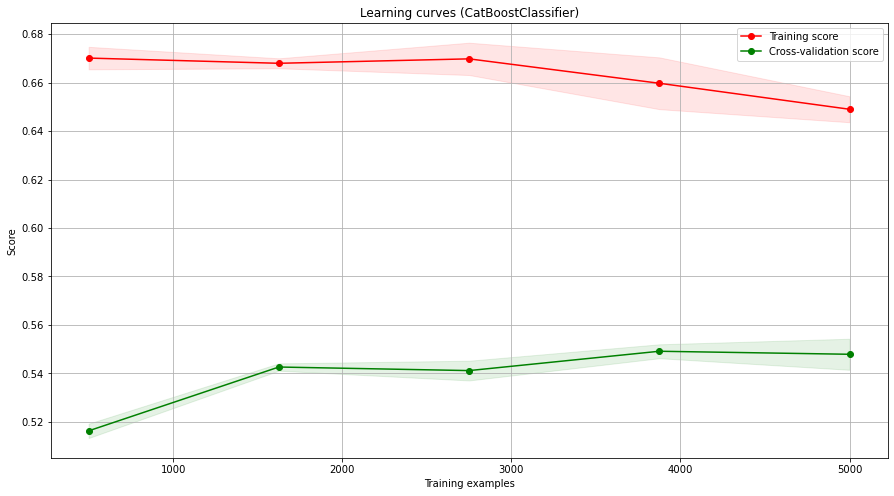

In [33]:
show_learning_curve_plot(CatBoost, X, y)

### Выбор порога вероятности для определения класса

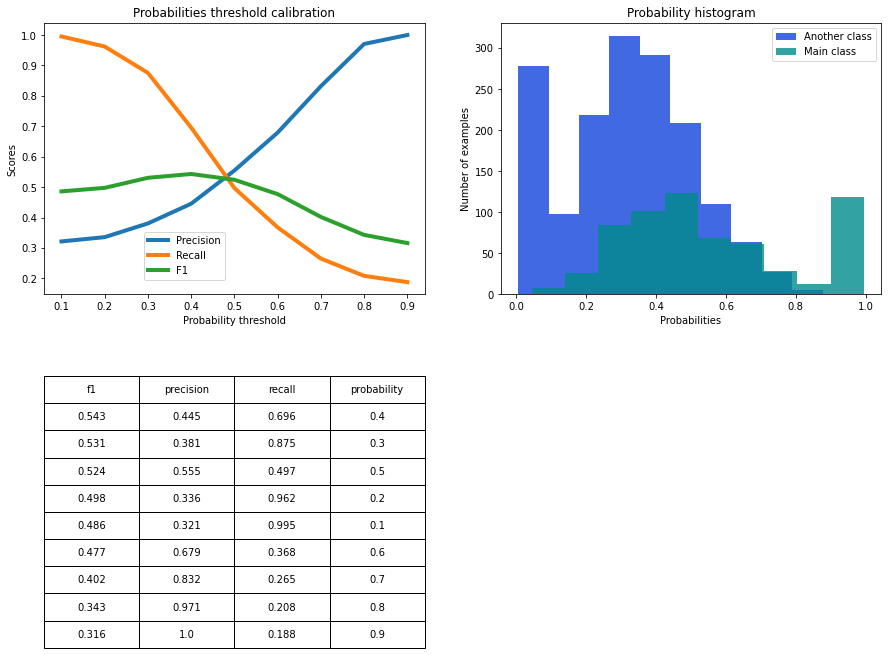

In [34]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

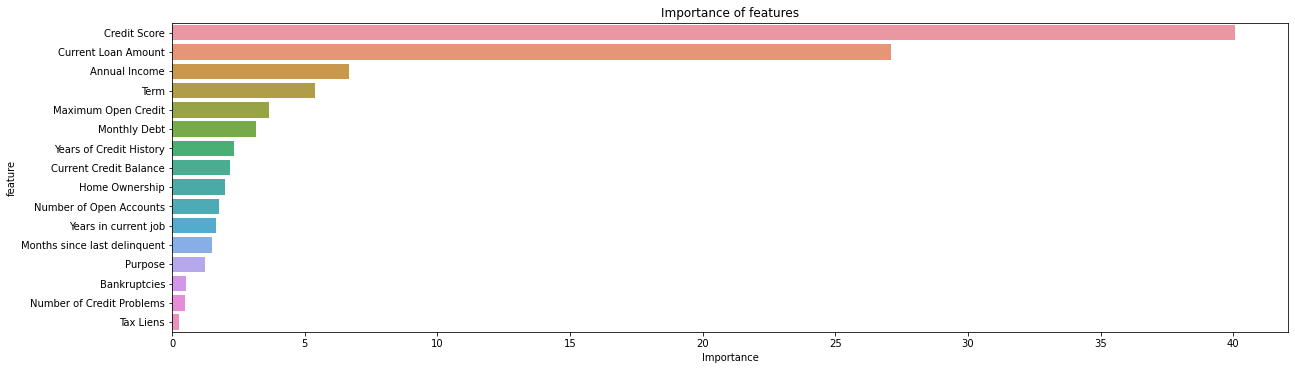

In [39]:
important_features_top = show_feature_importances(X_train.columns, CatBoost.feature_importances_,get_top=10)

In [36]:
important_features_top

['Number of Open Accounts',
 'Term',
 'Purpose',
 'Years in current job',
 'Home Ownership',
 'Annual Income',
 'Tax Liens',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems']

### Выбор оптимальной модели и параметров

In [37]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
CatBoost = cb.CatBoostClassifier(n_estimators=215, 
                                     depth=6,
                                     class_weights=class_weights,
                                     l2_leaf_reg=9, 
                                     thread_count=-1,
                                     random_state=50,
                                     silent=True)
CatBoost.fit(X_train, y_train)

y_train_pred = CatBoost.predict(X_train)
y_test_pred = CatBoost.predict(X_test)
y_test_pred_probs = CatBoost.predict_proba(X_test)
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
CatBoost.score(X_train, y_train)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      3771
           1       0.74      0.73      0.73      2958

    accuracy                           0.77      6729
   macro avg       0.76      0.76      0.76      6729
weighted avg       0.77      0.77      0.77      6729

TEST

              precision    recall  f1-score   support

           0       0.83      0.75      0.79      1616
           1       0.49      0.62      0.55       634

    accuracy                           0.71      2250
   macro avg       0.66      0.68      0.67      2250
weighted avg       0.74      0.71      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1212  404
1                241  393


0.7657898647644523

### Сохранение предсказаний

In [38]:
y_pred = CatBoost.predict(df_test)
save = pd.DataFrame(y_pred)
save.to_csv('Rogochiy_predictions.csv', index=None)